In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [4]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Adding a 'TotalSales' column which is the product of Quantity and UnitPrice
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# Extracting time-related features from 'InvoiceDate'
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Weekday'] = df['InvoiceDate'].dt.weekday  # Monday=0, Sunday=6
df['Hour'] = df['InvoiceDate'].dt.hour

# Remove rows with missing values
df.dropna(subset=['CustomerID', 'InvoiceNo', 'UnitPrice', 'Description'], inplace=True)

# Remove negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove duplicates
df.drop_duplicates(inplace=True)

# Check the processed data
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalSales  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34   

   Year  Month  Day  Weekday  Hour  
0  2010     12    1        2     8  
1  2010     12    1        2     8  

In [5]:
start_date = df['InvoiceDate'].min()
end_date = df['InvoiceDate'].max()

print(f"The date range is from {start_date} to {end_date}")

The date range is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [6]:
# Group by the date part of the InvoiceDate and sum the TotalSales for each group
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum()

# Print the daily sales
print(daily_sales)

InvoiceDate
2010-12-01     46192.49
2010-12-02     47197.57
2010-12-03     23876.63
2010-12-05     31361.28
2010-12-06     31009.33
                ...    
2011-12-05     58081.09
2011-12-06     45989.66
2011-12-07     69230.60
2011-12-08     50395.96
2011-12-09    184329.66
Name: TotalSales, Length: 305, dtype: float64


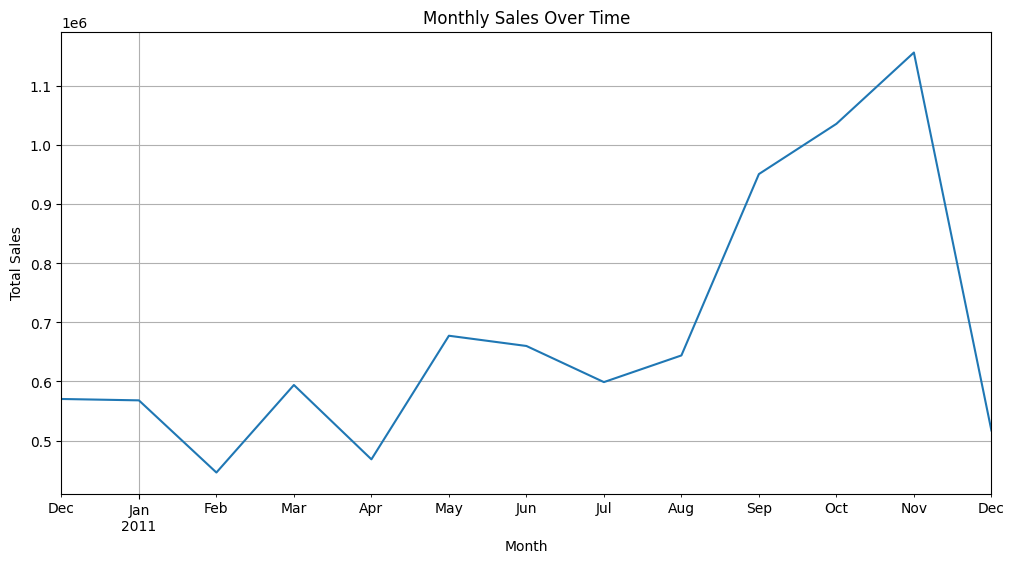

In [7]:
# monthly sales over time
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['TotalSales'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(title='Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

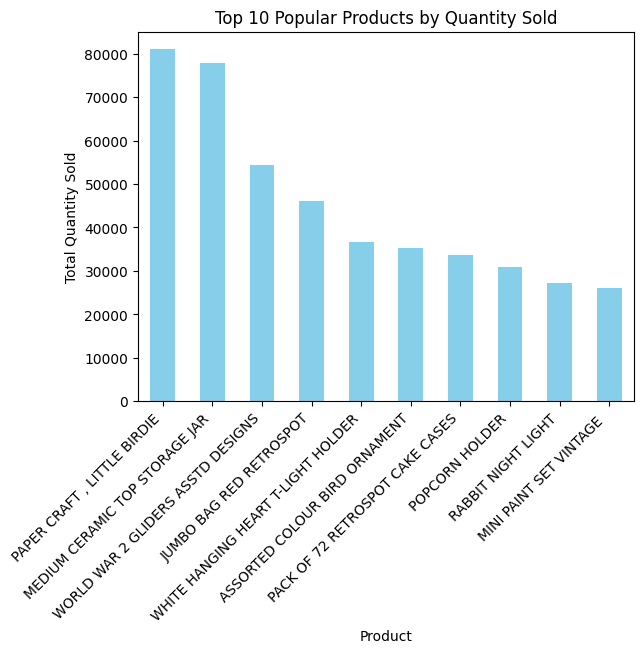

In [8]:
# 2. Popular Products and Categories
top_products = df.groupby('Description')['Quantity'].sum().nlargest(10)
top_products.plot(kind='bar', title='Top 10 Popular Products by Quantity Sold', color='skyblue')
plt.xlabel('Product')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.show()

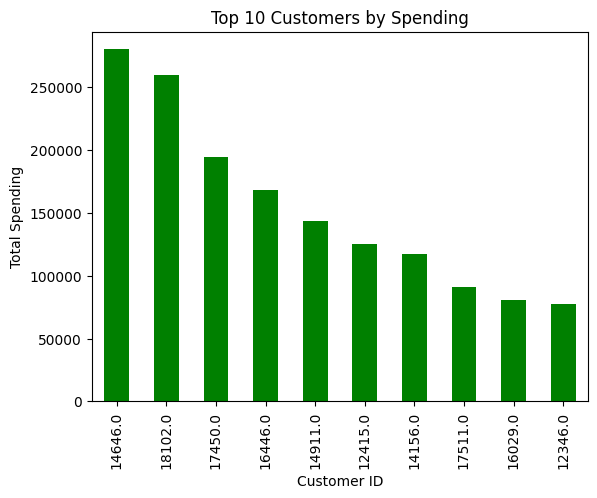

In [9]:
# 3. Customer Purchase Behavior Analysis
customer_spending = df.groupby('CustomerID')['TotalSales'].sum().nlargest(10)
customer_spending.plot(kind='bar', title='Top 10 Customers by Spending', color='green')
plt.xlabel('Customer ID')
plt.ylabel('Total Spending')
plt.show()

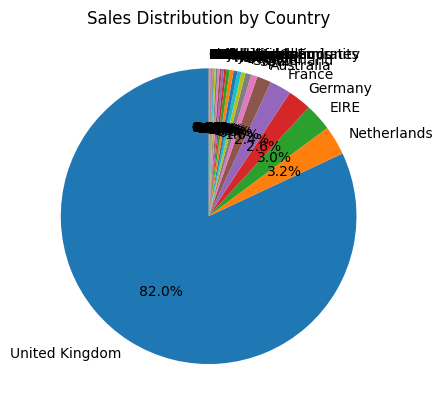

In [10]:
# 4. Geographical Distribution of Sales
country_sales = df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)
country_sales.plot(kind='pie', title='Sales Distribution by Country', autopct='%1.1f%%', startangle=90)
plt.ylabel('')  # Remove the y-label as it's obvious from the context
plt.show()

In [11]:
!pip install statsmodels

In [12]:
!pip install mlxtend

In [13]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Convert the data into a list of transactions
# Each transaction is a list of items bought together
transactions = df.groupby('InvoiceNo')['Description'].apply(list)

# Instantiate TransactionEncoder and encode the data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# Use the apriori algorithm to find frequent itemsets with a minimum support threshold
frequent_itemsets = apriori(df_transactions, min_support=0.01, use_colnames=True)

# Generate the rules with their corresponding support, confidence and lift
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the top 10 association rules sorted by lift
print(rules.sort_values('lift', ascending=False).head(10))

                                           antecedents  \
537                           (REGENCY TEA PLATE PINK)   
536                         (REGENCY TEA PLATE GREEN )   
904                    (POPPY'S PLAYHOUSE LIVINGROOM )   
901  (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...   
531                           (REGENCY MILK JUG PINK )   
530                         (REGENCY SUGAR BOWL GREEN)   
902  (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...   
903                       (POPPY'S PLAYHOUSE BEDROOM )   
540                         (REGENCY TEA PLATE ROSES )   
541                           (REGENCY TEA PLATE PINK)   

                                           consequents  antecedent support  \
537                         (REGENCY TEA PLATE GREEN )            0.012087   
536                           (REGENCY TEA PLATE PINK)            0.014569   
904  (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...            0.013598   
901                    (POPPY'S PLAYHOUSE LIVINGR

Mean Squared Error: 2157.0616802921995


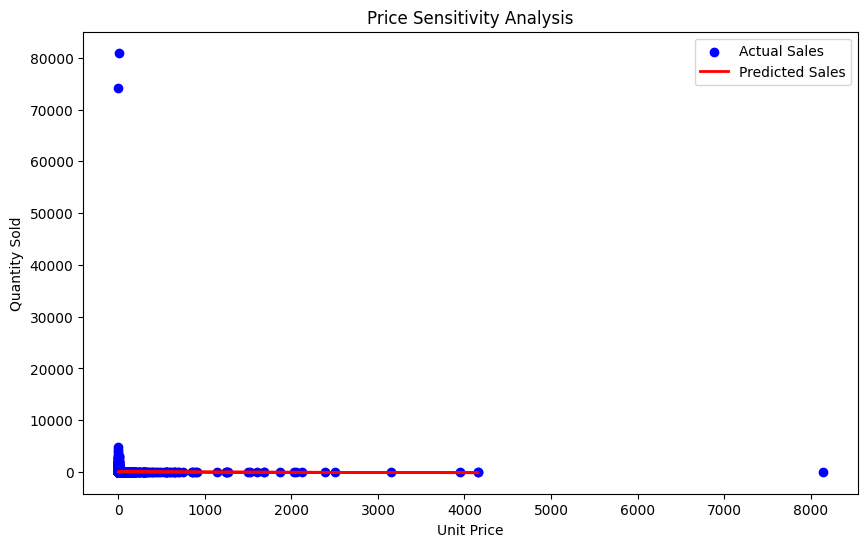

In [14]:
#Price Sensitivity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data for regression
X = df[['UnitPrice']]  # Predictor variable
y = df['Quantity']  # Response variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Sales')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Sales')
plt.title('Price Sensitivity Analysis')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

The Price Sensitivity Analysis plot reveals a concentration of sales at lower price points, with quantity sold decreasing as the price increases, which is a common demand trend. However, the flat red line representing the linear regression model's predictions suggests that, according to the model, there is little to no linear relationship between price and quantity sold. This indicates either that price is not the primary driver for quantity sold within this dataset, or that the relationship between price and demand is not linear and might require a more complex model to capture. 

New best ARIMA(0, 0, 0) MAPE=25.288
Error encountered with parameters (1, 2, 1): LU decomposition error.
Error encountered with parameters (1, 2, 2): LU decomposition error.
Error encountered with parameters (2, 1, 2): LU decomposition error.
Error encountered with parameters (2, 2, 0): LU decomposition error.
Error encountered with parameters (2, 2, 1): LU decomposition error.
Error encountered with parameters (2, 2, 2): LU decomposition error.
New best ARIMA(3, 0, 2) MAPE=23.306
Error encountered with parameters (3, 1, 2): LU decomposition error.
Error encountered with parameters (4, 1, 2): LU decomposition error.
Error encountered with parameters (4, 2, 0): LU decomposition error.
Error encountered with parameters (4, 2, 1): LU decomposition error.
Error encountered with parameters (4, 2, 2): LU decomposition error.
Error encountered with parameters (5, 0, 2): LU decomposition error.
Error encountered with parameters (5, 2, 0): LU decomposition error.
Error encountered with paramete

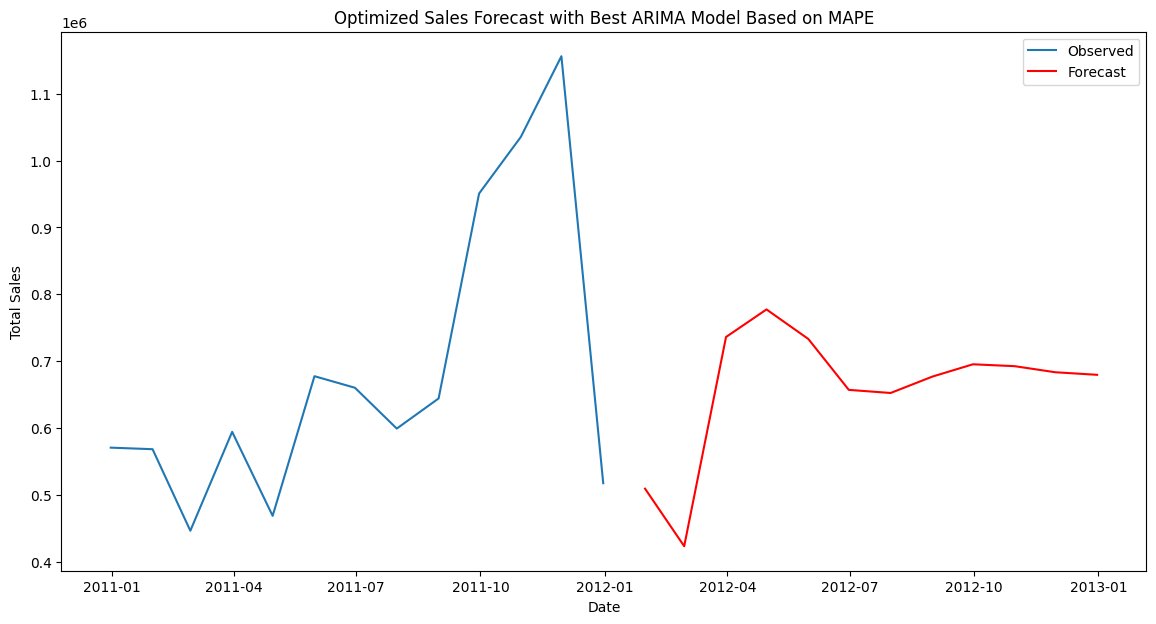

In [15]:
import numpy as np
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

time_series = df.set_index('InvoiceDate')['TotalSales'].resample('M').sum()

# Define the p, d, and q parameters
p = range(0, 6)  # AR terms
d = range(0, 3)  # Differencing terms, typically not more than 2
q = range(0, 6)  # MA terms

# Generate all different combinations of p, d, and q triplets
pdq_combinations = list(itertools.product(p, d, q))

# Define the number of folds for the cross-validation
tscv = TimeSeriesSplit(n_splits=3)

best_score, best_cfg = float("inf"), None

warnings.filterwarnings("ignore")  # Ignore warnings during grid search

# Grid search for the optimal ARIMA parameters
for pdq in pdq_combinations:
    mape_scores = []
    
    # Use a try-except block to catch and handle LinAlgError
    try:
        for train_index, test_index in tscv.split(time_series):
            train, test = time_series.iloc[train_index], time_series.iloc[test_index]
            history = list(train)
            predictions = []
            
            # Fit and forecast using ARIMA model
            for t in range(len(test)):
                model = ARIMA(history, order=pdq)
                model_fit = model.fit()
                yhat = model_fit.forecast()[0]
                predictions.append(yhat)
                history.append(test[t])
            
            # Calculate out of sample error using MAPE
            mape = np.mean(np.abs((test - predictions) / test)) * 100
            mape_scores.append(mape)
    
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"Error encountered with parameters {pdq}: {e}")
        continue  # Continue to the next parameter combination
    
    # Compute the average MAPE score for this parameter combination
    score = np.mean(mape_scores)
    if score < best_score:
        best_score, best_cfg = score, pdq
        print(f'New best ARIMA{pdq} MAPE={score:.3f}')

print(f'Best ARIMA{best_cfg} MAPE={best_score:.3f}')

# Fit the model with the best parameters to the entire dataset
model = ARIMA(time_series, order=best_cfg)
model_fit = model.fit()

print(model_fit.summary())

# Forecast beyond the end of the time series
forecast = model_fit.forecast(steps=12)

# Plotting observed values and forecasts
plt.figure(figsize=(14, 7))
plt.plot(time_series.index, time_series, label='Observed')
forecast_index = pd.date_range(start=time_series.index[-1], periods=13, freq='M')[1:]
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Optimized Sales Forecast with Best ARIMA Model Based on MAPE')
plt.legend()
plt.show()

New best ARIMA(0, 0, 0) RMSE=240855.623
New best ARIMA(0, 0, 1) RMSE=235696.669
New best ARIMA(0, 0, 2) RMSE=233141.724
New best ARIMA(0, 1, 1) RMSE=232532.698
Error encountered with parameters (1, 2, 1): LU decomposition error.
Error encountered with parameters (1, 2, 2): LU decomposition error.
New best ARIMA(2, 1, 0) RMSE=224862.693
Error encountered with parameters (2, 1, 2): LU decomposition error.
Error encountered with parameters (2, 2, 0): LU decomposition error.
Error encountered with parameters (2, 2, 1): LU decomposition error.
Error encountered with parameters (2, 2, 2): LU decomposition error.
Error encountered with parameters (3, 1, 2): LU decomposition error.
Error encountered with parameters (4, 1, 2): LU decomposition error.
Error encountered with parameters (4, 2, 0): LU decomposition error.
Error encountered with parameters (4, 2, 1): LU decomposition error.
Error encountered with parameters (4, 2, 2): LU decomposition error.
Error encountered with parameters (5, 0, 

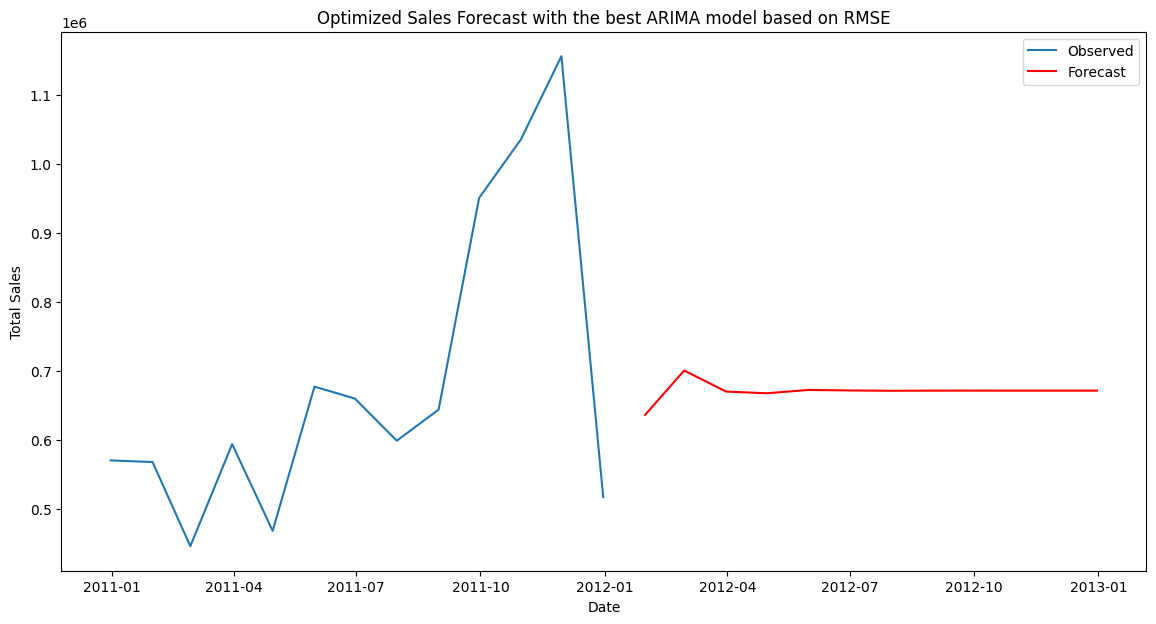

In [17]:
import numpy as np
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit

time_series = df.set_index('InvoiceDate')['TotalSales'].resample('M').sum()

# Define the p, d, and q parameters
p = range(0, 6)  # AR terms
d = range(0, 3)  # Differencing terms, typically not more than 2
q = range(0, 6)  # MA terms

# Generate all different combinations of p, d, and q triplets
pdq_combinations = list(itertools.product(p, d, q))

# Define the number of folds for the cross-validation
tscv = TimeSeriesSplit(n_splits=3)

best_score, best_cfg = float("inf"), None

warnings.filterwarnings("ignore")  # Ignore warnings during grid search

# Grid search for the optimal ARIMA parameters
for pdq in pdq_combinations:
    scores = []
    
    # Use a try-except block to catch and handle LinAlgError
    try:
        for train_index, test_index in tscv.split(time_series):
            # Split into train and test sets
            train, test = time_series.iloc[train_index], time_series.iloc[test_index]
            history = list(train)
            predictions = []
            
            # Fit and forecast using ARIMA model
            for t in range(len(test)):
                model = ARIMA(history, order=pdq)
                model_fit = model.fit()
                yhat = model_fit.forecast()[0]
                predictions.append(yhat)
                history.append(test[t])
            
            # Calculate out of sample error
            error = sqrt(mean_squared_error(test, predictions))
            scores.append(error)
    
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"Error encountered with parameters {pdq}: {e}")
        continue  # Continue to the next parameter combination
    
    # Compute the average RMSE score for this parameter combination
    score = np.mean(scores)
    if score < best_score:
        best_score, best_cfg = score, pdq
        print(f'New best ARIMA{pdq} RMSE={score:.3f}')

print(f'Best ARIMA{best_cfg} RMSE={best_score:.3f}')

# Fit the model with the best parameters to the entire dataset
model = ARIMA(time_series, order=best_cfg)
model_fit = model.fit()

# Forecast beyond the end of the time series
forecast = model_fit.forecast(steps=12)

# Plotting observed values and forecasts
plt.figure(figsize=(14, 7))
plt.plot(time_series.index, time_series, label='Observed')
forecast_index = pd.date_range(start=time_series.index[-1], periods=13, freq='M')[1:]
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Optimized Sales Forecast with the best ARIMA model based on RMSE')
plt.legend()
plt.show()

New best ARIMA(0, 0, 0) MAE=211054.706
New best ARIMA(0, 0, 2) MAE=203109.550
New best ARIMA(0, 1, 0) MAE=178815.375
Error encountered with parameters (1, 2, 1): LU decomposition error.
Error encountered with parameters (1, 2, 2): LU decomposition error.
New best ARIMA(2, 1, 0) MAE=178128.018
Error encountered with parameters (2, 1, 2): LU decomposition error.
Error encountered with parameters (2, 2, 0): LU decomposition error.
Error encountered with parameters (2, 2, 1): LU decomposition error.
Error encountered with parameters (2, 2, 2): LU decomposition error.
Error encountered with parameters (3, 1, 2): LU decomposition error.
Error encountered with parameters (4, 1, 2): LU decomposition error.
Error encountered with parameters (4, 2, 0): LU decomposition error.
Error encountered with parameters (4, 2, 1): LU decomposition error.
Error encountered with parameters (4, 2, 2): LU decomposition error.
Error encountered with parameters (5, 0, 2): LU decomposition error.
Error encountere

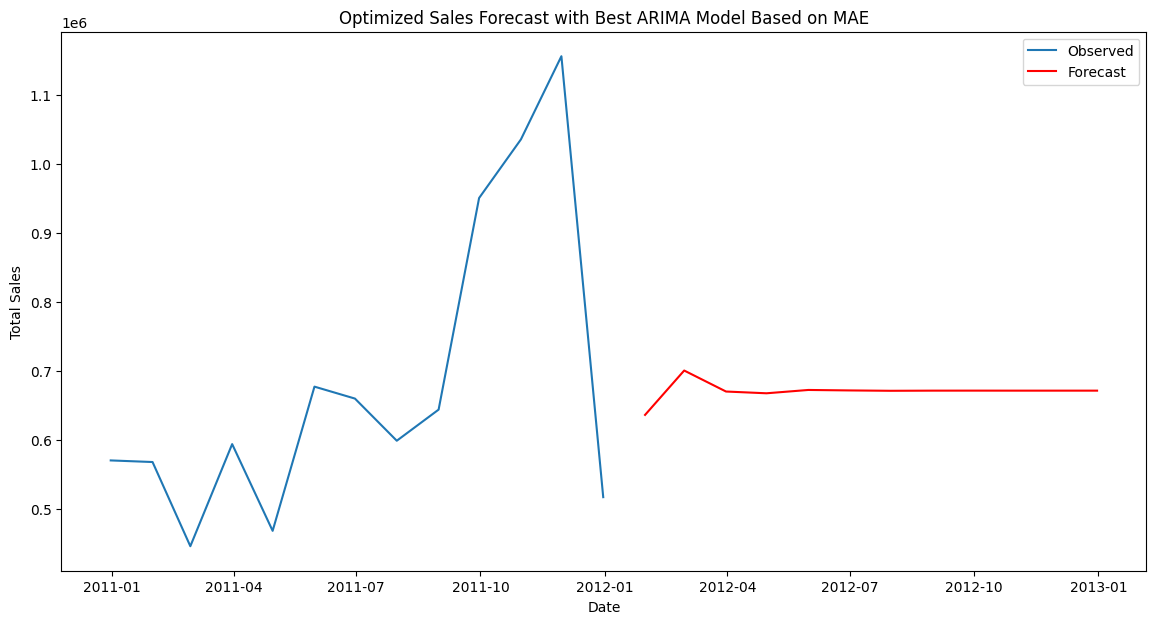

In [18]:
import numpy as np
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Define the p, d, and q parameters
p = range(0, 6)  # AR terms
d = range(0, 3)  # Differencing terms, typically not more than 2
q = range(0, 6)  # MA terms

# Generate all different combinations of p, d, and q triplets
pdq_combinations = list(itertools.product(p, d, q))

# Define the number of folds for the cross-validation
tscv = TimeSeriesSplit(n_splits=3)

best_score, best_cfg = float("inf"), None

warnings.filterwarnings("ignore")  # Ignore warnings during grid search

# Grid search for the optimal ARIMA parameters
for pdq in pdq_combinations:
    mae_scores = []
    
    # Use a try-except block to catch and handle LinAlgError
    try:
        for train_index, test_index in tscv.split(time_series):
            train, test = time_series.iloc[train_index], time_series.iloc[test_index]
            history = list(train)
            predictions = []
            
            # Fit and forecast using ARIMA model
            for t in range(len(test)):
                model = ARIMA(history, order=pdq)
                model_fit = model.fit()
                yhat = model_fit.forecast()[0]
                predictions.append(yhat)
                history.append(test[t])
            
            # Calculate out of sample error using MAPE
            mae = mean_absolute_error(test, predictions)
            mae_scores.append(mae)
    
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"Error encountered with parameters {pdq}: {e}")
        continue  # Continue to the next parameter combination
    
    # Compute the average MAPE score for this parameter combination
    score = np.mean(mae_scores)
    if score < best_score:
        best_score, best_cfg = score, pdq
        print(f'New best ARIMA{pdq} MAE={score:.3f}')

print(f'Best ARIMA{best_cfg} MAE={best_score:.3f}')

# Fit the model with the best parameters to the entire dataset
model = ARIMA(time_series, order=best_cfg)
model_fit = model.fit()

# Forecast beyond the end of the time series
forecast = model_fit.forecast(steps=12)

# Plotting observed values and forecasts
plt.figure(figsize=(14, 7))
plt.plot(time_series.index, time_series, label='Observed')
forecast_index = pd.date_range(start=time_series.index[-1], periods=13, freq='M')[1:]
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Optimized Sales Forecast with Best ARIMA Model Based on MAE')
plt.legend()
plt.show()